In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary

In [2]:
# Global variables
ratio_test = 0.1
ratio_dev = 0.1
nb_epoch = 10
batch_size = 16
learning_rate = 1e-3
save_plot_path_dnn = "training_plot_dnn.png"
save_plot_path_cnn = "training_plot_cnn.png"
evaluate_on_test_set = True

In [3]:
# Sets up computing device as GPU if one is available, CPU otherwise
if torch.cuda.device_count() > 0:
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print(f"Computation will be done on {device}")

Computation will be done on cpu


# Data Loading

In [4]:
# Import the whole dataset, download it if needed
dataset_full = torchvision.datasets.MNIST(root='datasets', download=True, transform=torchvision.transforms.ToTensor())

In [5]:
# Cut the whole dataset in train / test / dev subset index-wise
all_indexes = np.array([i for i in range(len(dataset_full))])
test_indexes = np.sort(np.random.choice(all_indexes, int(ratio_test * len(all_indexes))))
remaining_indexes = np.setdiff1d(all_indexes, test_indexes)
dev_indexes = np.sort(np.random.choice(remaining_indexes, int(ratio_dev * len(all_indexes))))
train_indexes = np.setdiff1d(remaining_indexes, dev_indexes)

In [6]:
# Actually cut the whole dataset in train / test / dev
dataset_train = torch.utils.data.Subset(dataset_full, train_indexes)
dataset_test = torch.utils.data.Subset(dataset_full, test_indexes)
dataset_dev = torch.utils.data.Subset(dataset_full, dev_indexes)

In [7]:
# Wrap the datasets to allow for easy batch-loading
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size)
dataloader_dev = torch.utils.data.DataLoader(dataset_dev, batch_size=batch_size)

In [8]:
# # Define a function to print a sample of the MNIST dataset
# def print_sample(sample):
#     image, label = sample
#     print(f"Label={label}")
#     plt.imshow(image)

In [9]:
# # Take a look at examples of the loaded dataset
# random_i = np.random.randint(len(dataset_dev))
# print_sample(dataset_dev[random_i])

# A new method of coding neural networks

In the previous exercise, we used the `Sequential` wrapper to build Neural Networks quickly and simply. Let us look at the more generic way of building a neural network, by inheriting from the `torch.nn.Module` class.

Using this method, two methods need to be defined when builing a new Neural Network. The function `__init__` defines the different layers and other objects that are necessary for the computation. The function `forward` then defines how those layers and objects interact with each other. For example, to build a Fully Connected Deep Neural Network with 3 hidden layer using ReLU activation functions, and a fully-connected output layer with a softmax activation function:

In [10]:
class DummyFullyConnectedNetwork(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super().__init__()
        self.layer_1 = torch.nn.Linear(input_dim, hidden_dim)
        self.layer_2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.layer_3 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.layer_4 = torch.nn.Linear(hidden_dim, output_dim)
        
        self.activation_1 = torch.nn.ReLU()
        self.activation_2 = torch.nn.ReLU()
        self.activation_3 = torch.nn.ReLU()
        self.activation_3 = torch.nn.Softmax()

    def forward(self, x):
        x = self.layer_1(x)
        x = self.activation_1(x)
        x = self.layer_2(x)
        x = self.activation_2(x)
        x = self.layer_3(x)
        x = self.activation_3(x)
        x = self.layer_4(x)
        x = self.activation_4(x)

        return x

print(DummyFullyConnectedNetwork(16, 10, 64))

DummyFullyConnectedNetwork(
  (layer_1): Linear(in_features=16, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_3): Linear(in_features=64, out_features=64, bias=True)
  (layer_4): Linear(in_features=64, out_features=10, bias=True)
  (activation_1): ReLU()
  (activation_2): ReLU()
  (activation_3): Softmax(dim=None)
)


For such a simple network, using the `Sequential` wrapper might have been easier, quicker and resulted in code easier to read. However, this method of building neural network is more versatile. For example, we can easily alter the code to allow for a variable amount of hidden layers by using a list of layers instead of hardcoding the number of layers in the network definition. This can be achieved thanks to the `ModuleList` wrapper:

In [11]:
class SmarterFullyConnectedNetwork(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, nb_hidden_layers):
        super().__init__()
        
        # Define layers
        self.layers = torch.nn.ModuleList()
        self.layers.append(torch.nn.Linear(input_dim, hidden_dim))
        for i in range(nb_hidden_layers):
            self.layers.append(torch.nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(torch.nn.Linear(hidden_dim, output_dim))

        # Define activation functions
        self.activations = torch.nn.ModuleList()
        for i in range(nb_hidden_layers + 1):
            self.activations.append(torch.nn.ReLU())
        self.activations.append(torch.nn.Softmax(dim=-1))

    def forward(self, x):
        for i in range(len(self.layers)):
            x = self.layers[i](x)
            x = self.activations[i](x)

        return x

print(SmarterFullyConnectedNetwork(16, 10, 64, 2))

SmarterFullyConnectedNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
  (activations): ModuleList(
    (0): ReLU()
    (1): ReLU()
    (2): ReLU()
    (3): Softmax(dim=-1)
  )
)


# Neural Networks for images

Up until now we have worked with data where each point of data was described with a single value for each of the input/output dimensions, either an integer or a real number. For example, when predicting `x+y` from `x` and `y` using mini-batch size, the shape of the input tensors was `(batch_size, 2)` and the shape of the output tensors was `(batch_size, 1)`.

In this exercise, we want to predict the hand-drawn digit on each image. The dataset contains digits `0` to `9` so we are tackling a 10-class classification problem. Using mini-batches, the shape of our output data would be `(batch_size, 10)`

Images are a more complex type of data. In the case of MNIST, images are in gray-scale, meaning that each pixel is represented with a single integer value, usually between 0 and 255. Thus, when using mini-batches with images of size `height * width` pixels, the shape of the input image batches would be `(batch_size, height, width, 1)`. In the case of RGB images, it would become `(batch_size, height, width, 3)` since each of the three color channels are encoded independently.

Fully-connected layers in a DNN accept inputs of shape `(batch_size, input_dim)`. Thus, in order to accept images as inputs of those fully-connected layers, we need to "flatten" the image. A tensor of shape `(batch_size, height, width, 1)` would become of shape `(batch_size, height * width * 1)` and a tensor of shape `(batch_size, height, width, 3)` would become of shape `(batch_size, height * width * 3)`. Visually, it could be represented as:

<Insert Image !>

The code for the network would become:

In [12]:
class ImageFullyConnectedNetwork(torch.nn.Module):
    def __init__(self, image_height, image_width, pixel_dim, output_dim, hidden_dim, nb_hidden_layers):
        super().__init__()
        
        # Define layers
        self.layers = torch.nn.ModuleList()
        self.layers.append(torch.nn.Linear(image_height * image_width * pixel_dim, hidden_dim))
        for i in range(nb_hidden_layers):
            self.layers.append(torch.nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(torch.nn.Linear(hidden_dim, output_dim))

        # Define activation functions
        self.activations = torch.nn.ModuleList()
        for i in range(nb_hidden_layers + 1):
            self.activations.append(torch.nn.ReLU())
        self.activations.append(torch.nn.LogSoftmax(dim=-1))

    def forward(self, x):
        x = x.flatten(1) # Collapse/Flatten everything after the first dimension of the tensor, ie. everything that isn't the batch size
        for i in range(len(self.layers)):
            x = self.layers[i](x)
            x = self.activations[i](x)

        return x

print(ImageFullyConnectedNetwork(image_height=27, image_width=27, pixel_dim=1, output_dim=10, hidden_dim=32, nb_hidden_layers=2))

ImageFullyConnectedNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=729, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=10, bias=True)
  )
  (activations): ModuleList(
    (0): ReLU()
    (1): ReLU()
    (2): ReLU()
    (3): LogSoftmax(dim=-1)
  )
)


# Training a neural network for image classification

In [13]:
# Build model
model_fc = ImageFullyConnectedNetwork(image_height=28, image_width=28, pixel_dim=1, output_dim=10, hidden_dim=32, nb_hidden_layers=2)
model_fc = model_fc.to(device)

# Define loss
loss_function = torch.nn.NLLLoss()

# Define optimizer
optimizer = torch.optim.SGD(params=model_fc.parameters(), lr=learning_rate)

In [14]:
# Training loop
def train_model(model):
    loss_train_overall, loss_dev_overall = [], []
    accuracy_train_overall, accuracy_dev_overall = [], []
    for epoch in range(1,nb_epoch+1): # Perform training and validation for an epoch (ie. Every sample of the dataset is seen exactly once.)
        
        # Perform training using mini-batches
        loss_train_epoch = []
        accuracy_train_epoch = []
        for i, batch_data in enumerate(dataloader_train):
            # Load a batch and perform feed-forward
            x, y_true =  batch_data

            # Move tensors to computing device (hardware acceleration if GPU, no difference if CPU)
            x = x.to(device)
            y_true = y_true.to(device)

            # Perform prediction
            y_pred = model(x)

            # Compute loss between prediction and ground-truth
            loss = loss_function(y_pred, y_true)
            loss_train_epoch.append(loss.item())

            # Compute accuracy between prediction and ground-truth
            pred_labels = torch.argmax(y_pred, 1) # Get the most probable label for each item in the batch
            good_pred = [1 if pred_labels[i] == y_true[i] else 0 for i in range(len(pred_labels))]
            accuracy = np.sum(good_pred) / len(good_pred)
            accuracy_train_epoch.append(accuracy)

            # Perform back-propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_train_overall.append(np.mean(loss_train_epoch))
        accuracy_train_overall.append(np.mean(accuracy_train_epoch))

        # At the end of an epoch, evaluate the model on the development set. It could be used to stop training when we diagnose over-fitting.
        loss_dev_epoch = []
        accuracy_dev_epoch = []
        for i, batch_data in enumerate(dataloader_dev):
            # Load a batch and perform feed-forward
            x, y_true =  batch_data
            x = x.to(device)
            y_true = y_true.to(device)
            y_pred = model(x)

            # Compute loss between prediction and ground-truth
            loss_dev_epoch.append(loss_function(y_pred, y_true).item())

            # Compute accuracy between prediction and ground-truth
            pred_labels = torch.argmax(y_pred, 1) # Get the most probable label for each item in the batch
            good_pred = [1 if pred_labels[i] == y_true[i] else 0 for i in range(len(pred_labels))]
            accuracy = np.sum(good_pred) / len(good_pred)
            accuracy_dev_epoch.append(accuracy)

        loss_dev_overall.append(np.mean(loss_dev_epoch))
        accuracy_dev_overall.append(np.mean(accuracy_dev_epoch))

        # Print training progress
        print(f"Epoch {epoch}/{nb_epoch}, loss_train={loss_train_overall[-1]}, loss_dev={loss_dev_overall[-1]}, acc_train={accuracy_train_overall[-1]}, acc_dev={accuracy_dev_overall[-1]}")
    return loss_train_overall, loss_dev_overall, accuracy_train_overall, accuracy_dev_overall

In [15]:
loss_train_overall, loss_dev_overall, accuracy_train_overall, accuracy_dev_overall = train_model(model_fc)

Epoch 1/10, loss_train=2.301841489337949, loss_dev=2.2931946468353273, acc_train=0.10042305045185229, acc_dev=0.10766666666666666
Epoch 2/10, loss_train=2.2746481012560333, loss_dev=2.2476102771759034, acc_train=0.18288983481955834, acc_dev=0.176
Epoch 3/10, loss_train=2.1855195024988228, loss_dev=2.095003382364909, acc_train=0.1992563887725178, acc_dev=0.22866666666666666
Epoch 4/10, loss_train=2.0008537240762942, loss_dev=1.8649049886067708, acc_train=0.29235367167394816, acc_dev=0.36466666666666664
Epoch 5/10, loss_train=1.6277771746154832, loss_dev=1.2679072666168212, acc_train=0.539235965647256, acc_dev=0.6831666666666667
Epoch 6/10, loss_train=1.006902835532346, loss_dev=0.8074663815498352, acc_train=0.7215927793404752, acc_dev=0.7608333333333334
Epoch 7/10, loss_train=0.7497186037939265, loss_dev=0.6641925404866537, acc_train=0.7771990394398229, acc_dev=0.7971666666666667
Epoch 8/10, loss_train=0.6334780110457054, loss_dev=0.5680267062584559, acc_train=0.8133453528038782, acc_de

In [16]:
# Once the architecture has been hand-crafted over multiple tries and evaluated with the dev-set, the developper might have 
# manually "over-fitted" the solution on the dev-set. We can then evaluate the final performances of the system on the test-set.

def evaluation(model):
    loss_test = []
    accuracy_test = []
    for i, batch_data in enumerate(dataloader_test):
        # Load a batch and perform feed-forward
        x, y_true =  batch_data
        x = x.to(device)
        y_true = y_true.to(device)
        y_pred = model(x)

        # Compute loss between prediction and ground-truth
        loss_test.append(loss_function(y_pred, y_true).item())

        # Compute accuracy between prediction and ground-truth
        pred_labels = torch.argmax(y_pred, 1) # Get the most probable label for each item in the batch
        good_pred = [1 if pred_labels[i] == y_true[i] else 0 for i in range(len(pred_labels))]
        accuracy = np.sum(good_pred) / len(good_pred)
        accuracy_test.append(accuracy)

    loss_test = np.mean(loss_test)
    accuracy_test = np.mean(accuracy_test)

    return loss_test, accuracy_test

loss_test, accuracy_test = 0, 0
if evaluate_on_test_set:
    loss_test, accuracy_test = evaluation(model_fc)

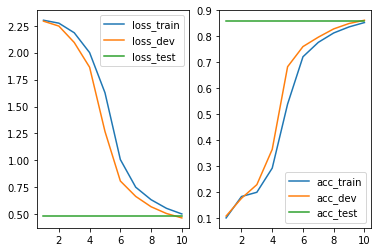

In [17]:
# Plot the training progress and saves it as a file
def plot(save_plot_path, loss_train_overall, loss_dev_overall, loss_test, accuracy_train_overall, accuracy_dev_overall, accuracy_test):
    fig, ax = plt.subplots(1, 2)

    x = [i for i in range(1,len(loss_train_overall)+1)]

    # Plot loss
    ax[0].plot(x, loss_train_overall, label="loss_train")
    ax[0].plot(x, loss_dev_overall, label="loss_dev")
    if evaluate_on_test_set:
        ax[0].plot(x, [loss_test]*len(x), label="loss_test")
    ax[0].legend()

    # Plot accuracy
    ax[1].plot(x, accuracy_train_overall, label="acc_train")
    ax[1].plot(x, accuracy_dev_overall, label="acc_dev")
    if evaluate_on_test_set:
        ax[1].plot(x, [accuracy_test]*len(x), label="acc_test")
    ax[1].legend()

    plt.savefig(save_plot_path)

plot(save_plot_path_dnn, loss_train_overall, loss_dev_overall, loss_test, accuracy_train_overall, accuracy_dev_overall, accuracy_test)


# Convolution layers : designed for images (and more ?)

We have seen that we can use fully connected layers to build neural networks that work on images. However, that solution has its issues, mainly due to the compression of an image as a single vector of size `height*width*pixel_dim`. More importantly we do not make use of the structure of an image. In images, patterns with semantic meaning might be found in groups of neighbouring pixels. However, fully-connected layers do not take local spatiality into account.

Convolution layers provide a solution. See https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53 for an introduction of how they work.

What follows is an implementation of DNN using convolution layers with PyTorch.

In [18]:
class ConvolutionNetwork(torch.nn.Module):
    def __init__(self, pixel_dim, intermediary_channels, kernel_size, nb_classes, image_width, image_height):
        super().__init__()
        self.layer_1 = torch.nn.Conv2d(pixel_dim, intermediary_channels, kernel_size)
        self.layer_2 = torch.nn.Conv2d(intermediary_channels, intermediary_channels, kernel_size)
        self.layer_3 = torch.nn.Conv2d(intermediary_channels, intermediary_channels, kernel_size)
        self.layer_4 = torch.nn.Linear(intermediary_channels*(image_width-(kernel_size-1)*3)*(image_height-(kernel_size-1)*3), nb_classes)

        self.final_activation = torch.nn.LogSoftmax(dim=-1)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = x.flatten(1)
        x = self.layer_4(x)
        x = self.final_activation(x)

        return x

print(ConvolutionNetwork(1, 6, 3, 10, 28, 28))

ConvolutionNetwork(
  (layer_1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (layer_2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1))
  (layer_3): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1))
  (layer_4): Linear(in_features=2904, out_features=10, bias=True)
  (final_activation): LogSoftmax(dim=-1)
)


In [19]:
# Build model
model_conv = ConvolutionNetwork(image_height=28, image_width=28, pixel_dim=1, intermediary_channels=3, kernel_size=4, nb_classes=10)
model_conv = model_conv.to(device)

# Define loss
loss_function = torch.nn.NLLLoss()

# Define optimizer
optimizer = torch.optim.SGD(params=model_conv.parameters(), lr=learning_rate)

# Train the model
loss_train_overall, loss_dev_overall, accuracy_train_overall, accuracy_dev_overall = train_model(model_conv)

Epoch 1/10, loss_train=1.0898376982815445, loss_dev=0.40668828117350736, acc_train=0.69050362080316, acc_dev=0.8711666666666666
Epoch 2/10, loss_train=0.3657845415354604, loss_dev=0.35899022967368366, acc_train=0.8953670177748518, acc_dev=0.885
Epoch 3/10, loss_train=0.34149714909313666, loss_dev=0.3424706707124909, acc_train=0.9025674786043449, acc_dev=0.8943333333333333
Epoch 4/10, loss_train=0.3298092198566122, loss_dev=0.3334399305532376, acc_train=0.9054888084265964, acc_dev=0.898
Epoch 5/10, loss_train=0.3224072798965787, loss_dev=0.327253197748214, acc_train=0.9081015470704411, acc_dev=0.8991666666666667
Epoch 6/10, loss_train=0.31708740818217995, loss_dev=0.32256899366900327, acc_train=0.9099119486504279, acc_dev=0.9005
Epoch 7/10, loss_train=0.31300624102228974, loss_dev=0.31885951239118976, acc_train=0.9117017774851877, acc_dev=0.902
Epoch 8/10, loss_train=0.30974574760721485, loss_dev=0.3158258384478589, acc_train=0.912421823568137, acc_dev=0.9028333333333334
Epoch 9/10, los

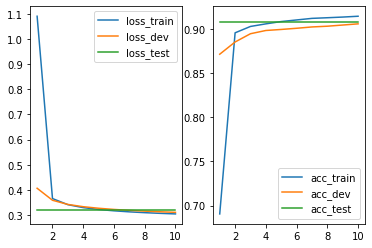

In [20]:
loss_test, accuracy_test = 0, 0
if evaluate_on_test_set:
    loss_test, accuracy_test = evaluation(model_conv)

plot(save_plot_path_cnn, loss_train_overall, loss_dev_overall, loss_test, accuracy_train_overall, accuracy_dev_overall, accuracy_test)

Let us look at the number of parameters of the Feed-Forward DNN and the convolution-based DNN.

In [21]:
summary(model_fc, (1, 28, 28))
summary(model_conv, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]          25,120
              ReLU-2                   [-1, 32]               0
            Linear-3                   [-1, 32]           1,056
              ReLU-4                   [-1, 32]               0
            Linear-5                   [-1, 32]           1,056
              ReLU-6                   [-1, 32]               0
            Linear-7                   [-1, 10]             330
        LogSoftmax-8                   [-1, 10]               0
Total params: 27,562
Trainable params: 27,562
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.11
Estimated Total Size (MB): 0.11
----------------------------------------------------------------
--------------------------------------------

The convolution-based network has half as much parameters than the feed-forward DNN but offers better performance !